# X-RAY-Classifier

 $Team$  $Softmax$,                                  May 21th 2021
 
X-RAY-Classifier classification is is a solution to [X-RAY Classification](https://www.kaggle.com/c/acse4-ml-2020). The goal of this Kaggle competition is to classify a dataset of X-Ray lung images into 4 classes. The goal is to correctly label all the images in the test dataset. The final output is the prediction result in `csv` format as the submission file for the competition.

## Importing the necessary libraries

In [1]:
!pip install pycm livelossplot progressbar torchsummary
%pylab inline

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import random
import progressbar
import copy
import cv2
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sns

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Description of the Dataset

The 4 classes of dataset are:
- Covid-19: lung images of Covid-19 patients.
- Lung opacity (ground-glass opacity): images of lungs showing areas of hazy opacification or increased attenuation (CT) due to air displacement by fluid, airway collapse, fibrosis, or a neoplastic process.
- Pneumonia: lung images of viral pneumonia patients.
- Normal: lung images of healthy patients.

Target keys for the submission files:

```
{
"covid":0,
"lung_opacity":1,
"pneumonia":2,
"normal":3
}
```

In [3]:
labels = ["covid", "lung_opacity", "pneumonia", "normal"]
img_size = 224

def load_training_data(data_dir):
    """
    Load in training data.
    input: data_dir, str, path of data folder.
    output: np.array(data), np.array of the loaded dataset.
    """
    
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img.endswith('.png') != True:
                continue
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Read in images in Grayscale
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

def load_test_data(data_dir):
    """
    Load in test data.
    input: 
    data_dir, str, path of data folder.
    output: 
    np.array(data), np.array of the loaded dataset.
    file_names, list of names of each images.
    """
    
    data = []
    file_names = []
    path = data_dir
    class_num = 0
    #for img in os.listdir(path):
    for i in range(950):
        img = 'test_%d.png'%i
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
            file_names.append(img.replace('.png',''))
        except Exception as e:
            print(e)
    return np.array(data), file_names

## Loading the Dataset

First you need to go to [kaggle](https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials which you must upload to colab. Then you must move this file to your root directory and request a forced update of kaggle in pip to download your data correctly, which is writen in `download_data.sh` and can be easily executed by `bash download_data.sh`.

Change the following path to your own path of train and test set, and run this block to load dataset.

In [4]:
train_init = load_training_data('./input/acse4-ml-2020/xray-data/xray-data/train')
test_init, test_names = load_test_data('./input/acse4-ml-2020/xray-data/xray-data/test')

## Data Visualization & Preprocessing

<AxesSubplot:ylabel='count'>

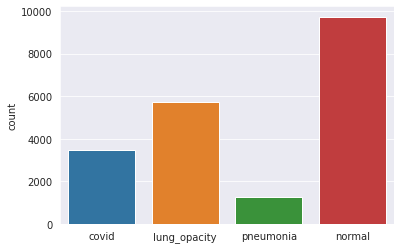

In [5]:
l = []
for data in train_init:
    if(data[1] == 0):
        l.append("covid")
    if(data[1] == 1):
        l.append("lung_opacity")
    if(data[1] == 2):
        l.append("pneumonia")
    if(data[1] == 3):
        l.append("normal")
sns.set_style('darkgrid')
sns.countplot(l)

In [6]:
myset = set(l)
for item in myset:
    print("the %s has found %d" %(item,l.count(item)))

the covid has found 3454
the lung_opacity has found 5742
the normal has found 9734
the pneumonia has found 1285


The data seems imbalanced . To increase the no. of training examples, we will use data augmentation.

Previewing the images of all classes:

Text(0.5, 1.0, 'normal')

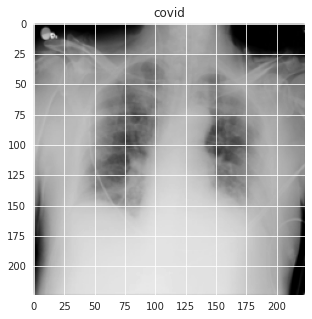

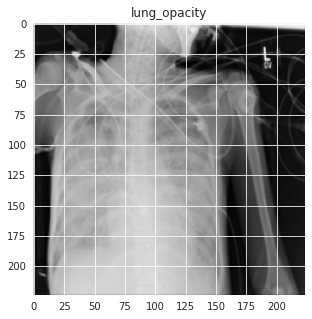

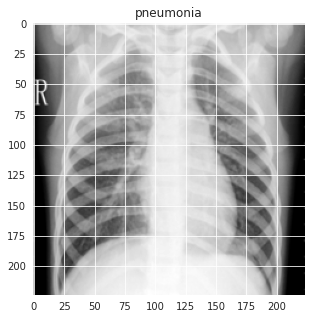

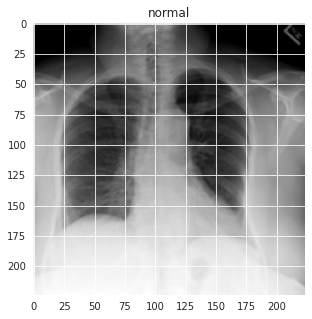

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train_init[0][0], cmap='gray')
plt.title(labels[train_init[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train_init[4000][0], cmap='gray')
plt.title(labels[train_init[4000][1]])

plt.figure(figsize = (5,5))
plt.imshow(train_init[10000][0], cmap='gray')
plt.title(labels[train_init[10000][1]])

plt.figure(figsize = (5,5))
plt.imshow(train_init[-2][0], cmap='gray')
plt.title(labels[train_init[-2][1]])

In [8]:
train_data = []
train_targets = []

test_data = []
test_targets = []

for feature, label in train_init:
    train_data.append(feature)
    train_targets.append(label)

for feature, label in test_init:
    test_data.append(feature)
    test_targets.append(label)

In [9]:
train_data = np.array(train_data)
test_data = np.array(test_data)
print(train_data.shape)
print(test_data.shape)

(20215, 224, 224)
(950, 224, 224)


Split train and validation set:

In [10]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, train_size = 0.8, test_size=0.2, random_state=42).split(train_data, train_targets) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [11]:
print(len(indices[0]))

16172


We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [12]:
# calculate mean and std
mean = train_data.mean()/255
std = train_data.std()/255
print(mean)
print(std)

0.5089942062575092
0.252348941604565


In [13]:
def apply_normalisation(X):
    """
    Normalise the set X
    input: X, an array of numbers that is ready to be normalised
    output: normalised X
    """
    X = torch.Tensor(X)
    
    X /= 255.
    X -= mean
    X /= std
    return X

In [14]:
X_train, y_train = apply_normalisation(train_data[indices[0]]), torch.Tensor(train_targets)[indices[0]]
X_val, y_val = apply_normalisation(train_data[indices[1]]), torch.Tensor(train_targets)[indices[1]]
X_test, y_test = apply_normalisation(test_data), torch.Tensor(test_targets)

xray_train = TensorDataset(X_train, y_train.long())
xray_validate = TensorDataset(X_val, y_val.long())
xray_test = TensorDataset(X_test, y_test.long())

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([16172, 224, 224])
torch.Size([4043, 224, 224])
torch.Size([950, 224, 224])


## Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [15]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomCrop(224, padding=20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.509,), (0.253,))
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.509,), (0.253,))
])

For the data augmentation, we choosed to :

- Randomly flip images horizontally

- Randomly rotate some training images by 10 degrees

- Randomly shift images horizontally and vertically by 20 pixels

Once our model is ready, we fit the training dataset.

In [16]:
class CustomImageTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
        data (Tensor): A tensor containing the data e.g. images
        targets (Tensor): A tensor containing all the labels
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(-1, 224, 224)
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [17]:
X_train, y_train = torch.Tensor(train_data)[indices[0]], torch.Tensor(train_targets)[indices[0]]
X_val, y_val = torch.Tensor(train_data)[indices[1]], torch.Tensor(train_targets)[indices[1]]
X_test, y_test = torch.Tensor(test_data), torch.Tensor(test_targets)

xray_custom_train = CustomImageTensorDataset(X_train, y_train.long(), transform=train_transform)
xray_validate = CustomImageTensorDataset(X_val, y_val.long(), transform=val_test_transform)
xray_test = CustomImageTensorDataset(X_test, y_test.long(), transform=val_test_transform)

print(xray_train.__len__())
print(xray_validate.__len__())
print(xray_test.__len__())

16172
4043
950


## Training the Model

ResNet-18 is a convolutional neural network that is 18 layers deep. In this project, we choose the ResNet18 as data training model. 

Since our image is in grayscale format, we need to change the channel of the layer to 1.

In [18]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
model.to(device)
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Using `wandb`

wandb is the abbreviation of Weights & Biases, this tool can help track your machine learning projects. It can automatically record the hyperparameters and output indicators during the model training process, then visualize and compare the results, and quickly share the results with colleagues. In the following training process, we use wandb to record the results.

In [20]:
!pip install wandb

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


The following parameter settings are the best parameters we have chosen for classifier $Orchid$([see here for details](#section_id)), and you can directly use them to train the model.

If you want to set your own parameters, please start from this block, enter new parameters and rerun all subsequent modules to record new training data.

In [24]:
import wandb

# Initialize a new run and set hyperparameters
#wandb.login(key='8ebeb3b9dc218ff686b10d97c906d8a84b6d0a1a')
wandb.init(project='ResNet18', entity='x-ray-classification-softmax')
wandb.watch_called = False  # Re-run the model without restarting the runtime, unnecessary after our next release

# config is a variable that holds and saves hyper parameters and inputs
config = wandb.config  # Initialize config
config.seed = 42  # random seed(default:42)
config.lr = 1e-1  # learning rate(default:0.01)
config.momentum = 0.5  # SGD momentum(default:0.5)
config.batch_size = 32  # input batch size for training (default:64)
config.test_batch_size = 1000  # input batch size for testing(default:1000)
config.epochs = 50  # number of epochs to train(default:10)
config.weight_decay = 1e-3
config.no_cuda = False  # disables CUDA training
config.log_interval = 10  # how many batches to wait before logging training status

In [22]:
def train(config, model, optimizer, criterion, data_loader):
    """
    Implement train function.
    input:
    config, config paramters of wandb.
    model, model to be trained.
    optimiser, optimisation method.
    criterion, a function that calculates loss.
    data_loader, torch.Tensor, data to be input.
    output:
    train_loss, float, loss of training dataset.
    train_accuracy, float, loss of training dataset.
    """
    
    model.train()    #switch model to training mode
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()    # Reset the gradients to 0 for all learnable weight parameters
        a2 = model(X.reshape(-1, 1, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()
    
    # wandb.log is used to record some logs (accuracy, loss and epoch), 
    # so that you can check the performance of the network at any time
    wandb.log({
        "Train Accuracy": train_accuracy/len(data_loader.dataset),
        "Train Loss": train_loss/len(data_loader.dataset)
    })
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    Implement validate function.
    input:
    model, model to be trained.
    optimiser, optimisation method.
    criterion, a function that calculates loss.
    data_loader, torch.Tensor, data to be input.
    output:
    validation_loss, float, loss of validation dataset.
    validation_accuracy, float, accuracy of validation dataset.
    """
    
    model.eval()    # switch model to evaluation mode
    validation_loss, validation_accuracy = 0., 0.
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            a2 = model(X.reshape(-1, 1, 224, 224))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
    
    wandb.log({
        "Validation Accuracy": validation_accuracy/len(data_loader.dataset),
        "Validation Loss": validation_loss/len(data_loader.dataset)
    })
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    """
    Implement evaluate function.
    input:
    model, model have been trained.
    data_loader, torch.Tensor, data to be input.
    output:
    y_preds, numpy.array, predicted labels.
    ys, numpy.array, actual labels.
    """
    
    model.eval()    # switch model to evaluation mode
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.reshape(-1, 1, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [23]:
def train_model(plot=True):
    """
    Training model with this function.
    intput:
    plot:, boolean, to tell whether live update is plotted or not.
    output:
    model, final model trained.
    """
    
    set_seed(config.seed)
    model = models.resnet18()
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.8, last_epoch=-1)
    criterion = nn.CrossEntropyLoss()
    
    train_loader = DataLoader(xray_custom_train, batch_size=config.batch_size, shuffle=True, num_workers=0)
    validation_loader = DataLoader(xray_validate, batch_size=config.test_batch_size, shuffle=False, num_workers=0)
    
    # wandb.watch() automatically fetches all layer dimensions, gradients, model parameters
    # and logs them automatically to your dashboard.
    # using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")
    liveloss = PlotLosses()
    for epoch in range(config.epochs):
        logs = {}
        train_loss, train_accuracy = train(config, model, optimizer, criterion, train_loader)
        
        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()
        
        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()
        
        liveloss.update(logs)
        if plot:
            liveloss.draw()
        scheduler.step()

    return model

### Parameters tuning process

The learning rate refers to the magnitude of the update of the network weights in the optimization algorithm. When the learning rate is too large, the model may not converge, and the loss will continue to oscillate up and down; when the learning rate is too small, the model will converge slowly, and it will take longer to train.

We first determine the initial value of the learning rate. The selected learning rate range is as follows:

$lr = [0.01, 0.1, 0.5]$

![avatar](./resource/lr.png)

Train accuracy: $[0.9993, 0.9993, 0.9977]$

Validation accuracy: $[0.9206, 0.9263, 0.9236]$

From above we know all 3 trainings can converge in a suitable time. The accuracy of training is not much different. When `lr = 0.1`, the verification accuracy rate is relatively high, and the verification accuracy rate curve and the loss curve have few fluctuations. Therefore we choose `lr = 0.1` as initial learning rate.

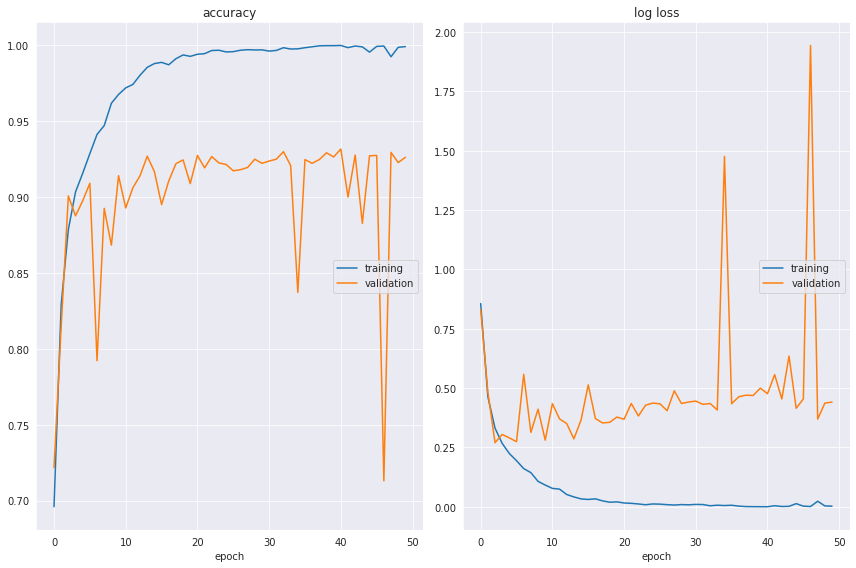

accuracy
	training         	 (min:    0.696, max:    1.000, cur:    0.999)
	validation       	 (min:    0.713, max:    0.932, cur:    0.926)
log loss
	training         	 (min:    0.000, max:    0.856, cur:    0.003)
	validation       	 (min:    0.270, max:    1.943, cur:    0.441)


In [30]:
# lr=1e-1
model = train_model(plot=True)

At the beginning of training, the learning rate should be large, so that the network can converge fast. In the later stage of training, it is better to use a smaller learning rate to make the network better converge to the optimal solution. Here we introduce the learning rate decay strategy to make the learning rate decay exponentially.

The formula for exponential decay is as follows:

$$
lr = lr_0 \gamma^n
$$

Where $\gamma$ is the base and $n$ is epoch.

Choose different $\gamma$ values can obtain decay curves with different amplitudes. If $\gamma$ is too large, the decay is too slow to achieve the purpose of learning rate decay; if $\gamma$ is too small, the decay is too fast, and it is likely to decay to a very small learning rate before convergence.

Observing the above curve of `lr = 0.1`, we can see that the convergence process mainly occurs in the epoch interval [0, 20]. Therefore, we assume that the exponential decay curve should also decay to a smaller learning rate within 20 epochs to achieve the best results.

The $\gamma$ range we choose is:

$\gamma = [0.6, 0.7, 0.8]$

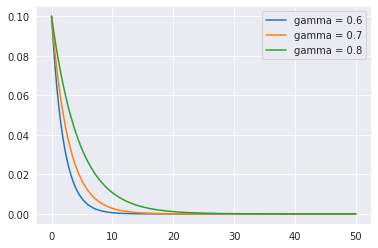

In [120]:
x = np.linspace(0, 50, 500)
a = 0.1*np.power(0.6, x)
b = 0.1*np.power(0.7, x)
c = 0.1*np.power(0.8, x)

plt.plot(x, a, label='gamma = 0.6')
plt.plot(x, b, label='gamma = 0.7')
plt.plot(x, c, label='gamma = 0.8')
plt.legend()
plt.show()

The figure above shows the decay rate curve when the gamma value is different. 

![avatar](./resource/gamma.png)

Train accuracy: $[0.9981, 0.9996, 0.9999]$

Validation accuracy: $[0.9213, 0.9243, 0.9241]$

It can be seen from the above comparison that when `gamma = 0.8`, the accuracy is relatively high, the train loss is the smallest, and the curve during the training process are more smooth. Therefore we choose `gamma = 0.8` as the base of exponential decay.

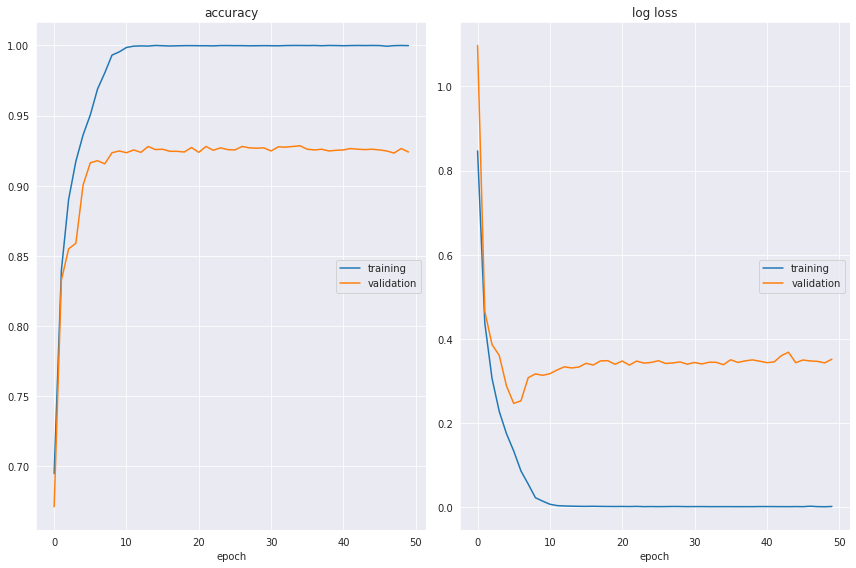

accuracy
	training         	 (min:    0.695, max:    1.000, cur:    1.000)
	validation       	 (min:    0.671, max:    0.929, cur:    0.924)
log loss
	training         	 (min:    0.001, max:    0.847, cur:    0.002)
	validation       	 (min:    0.247, max:    1.097, cur:    0.352)


In [87]:
#lr = 1e-1, gamma = 0.8
model = train_model(plot=True)

Observing the results after adding the learning rate decay strategy, it can be seen that after applying the decay strategy, the smoothness of the result curve is significantly improved, and the convergence effect is better. However, the gap between the accuracy of the training set and the validation set is still large, and there is an over-fitting occurred. We can add `weight_decay` to prevent overfitting.

In the loss function, weight decay is a coefficient placed in front of regularization. The regular term generally indicates the complexity of the model, so the role of weight decay is to adjust the influence of the complexity of the model on the loss function. If the weight decay is large, the value of the complex model loss function is also large.

The selected `weight_decay` range is as follows:

wd = $[0.001, 0.0001, 0.00001]$

![avatar](./resource/wd.png)

Train accuracy: $[0.9999, 0.9999, 0.9998]$

Validation accuracy: $[0.9298, 0.9285, 0.9283]$

The above figure shows the accuracy and loss curve of wd at different times. We found that the performance difference is not obvious. When `weight_decay = 1e-3`, the performance is slightly better than others. We choose `weight_decay = 1e-3`, but `weight_decay = 1e-4` can also be used as alternatives.

$Iris: lr=0.1, gamma=0.8, wd=0.001$

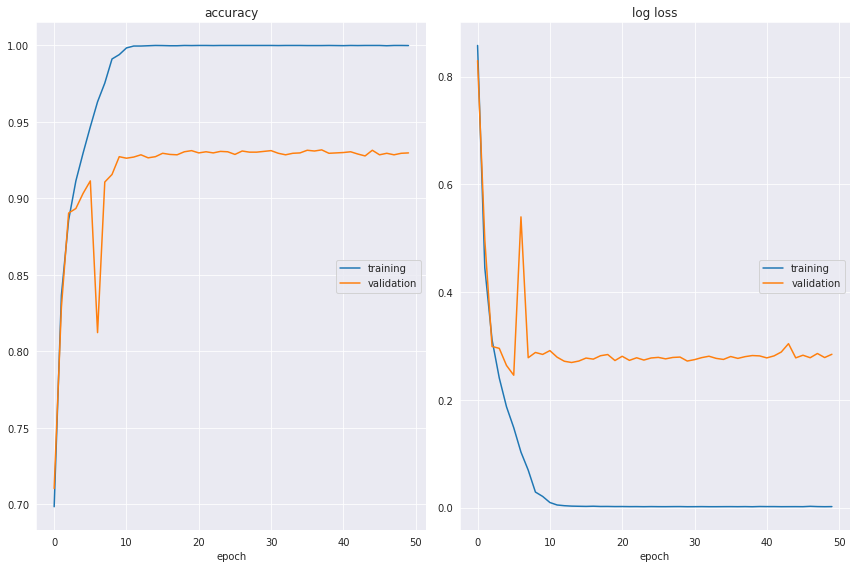

accuracy
	training         	 (min:    0.698, max:    1.000, cur:    1.000)
	validation       	 (min:    0.710, max:    0.932, cur:    0.930)
log loss
	training         	 (min:    0.001, max:    0.858, cur:    0.002)
	validation       	 (min:    0.246, max:    0.830, cur:    0.284)


In [20]:
model = train_model(plot=True)

$Jasmine: lr=0.1, gamma=0.8, wd=0.0001$

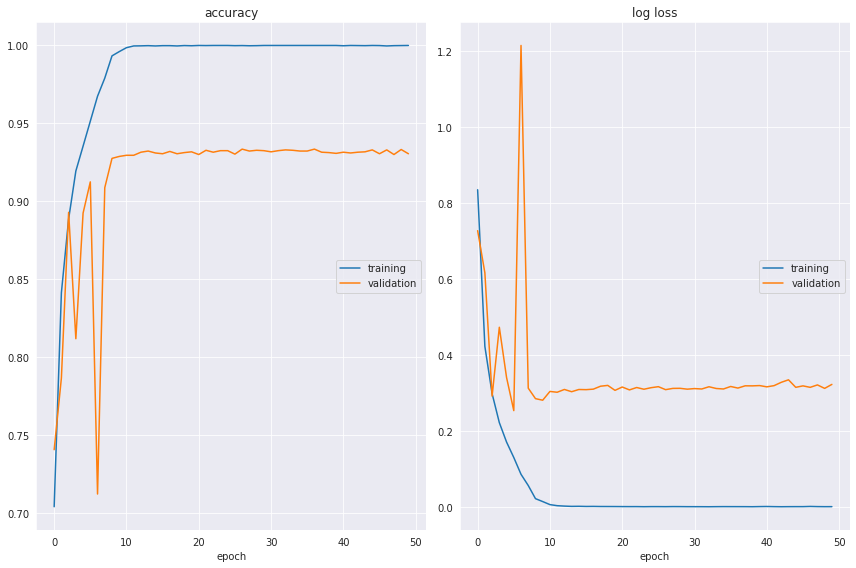

accuracy
	training         	 (min:    0.704, max:    1.000, cur:    1.000)
	validation       	 (min:    0.712, max:    0.933, cur:    0.930)
log loss
	training         	 (min:    0.001, max:    0.836, cur:    0.001)
	validation       	 (min:    0.254, max:    1.215, cur:    0.323)


In [124]:
model = train_model(plot=True)

After adding `weight_decay`, we found that overfitting still exists. We tried to add a Dropout layer to prevent overfitting, but the effect was reduced. It is speculated that this is because the BatchNormalization layer is added to the ResNet network, so there is no need to add the Dropout layer.

Next, we apply data augmentation.

$Orchid: lr=0.1, gamma=0.8, wd=0.001,$ $with$ $data$ $augmentation$

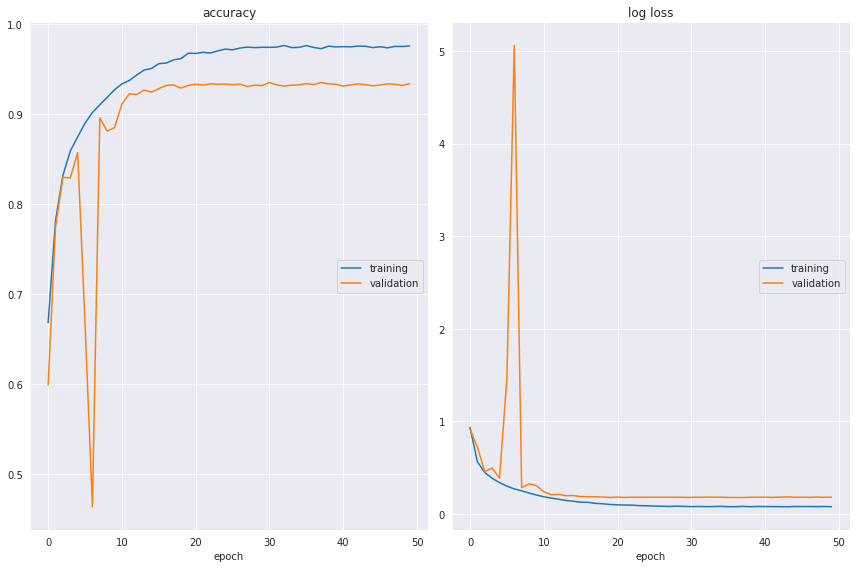

accuracy
	training         	 (min:    0.668, max:    0.976, cur:    0.976)
	validation       	 (min:    0.464, max:    0.935, cur:    0.934)
log loss
	training         	 (min:    0.077, max:    0.935, cur:    0.078)
	validation       	 (min:    0.177, max:    5.061, cur:    0.180)


In [38]:
model = train_model(plot=True)

$Peony: lr=0.1, gamma=0.8, wd=0.0001,$ $with$ $data$ $augmentation$

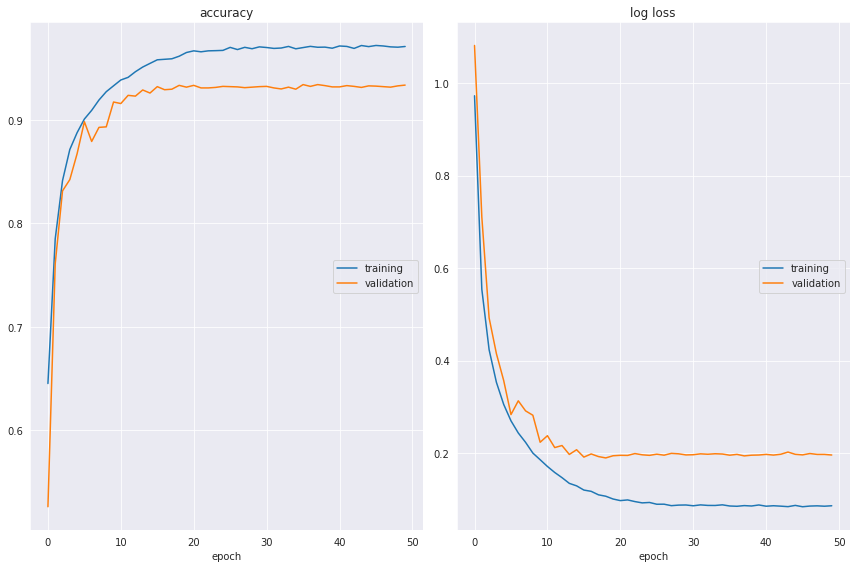

accuracy
	training         	 (min:    0.645, max:    0.972, cur:    0.971)
	validation       	 (min:    0.526, max:    0.934, cur:    0.933)
log loss
	training         	 (min:    0.084, max:    0.973, cur:    0.086)
	validation       	 (min:    0.190, max:    1.081, cur:    0.196)


In [145]:
model = train_model(plot=True)

After adding data augmentation, the accuracy gap between the training and the validation accurancy is significantly smaller, successfully preventing overfitting.

The following is the enhancement demonstration. After tuning the parameters, the accuracy of the verification set is improved, the loss is reduced, the convergence curve is smoothed, and the convergence effect is better.

![avatar](./resource/enhancement.png)

Train accuracy: $[0.9993, 0.9999, 0.9999, 0.9755]$

Validation accuracy: $[0.9263, 0.9241, 0.9298, 0.9337]$

### Train with best hyperparameters on full dataset

Strategy A:

$Orchid: lr=0.1, gamma=0.8, wd=0.001,$ $with$ $data$ $augmentation$

In [48]:
X_train, y_train = torch.Tensor(train_data), torch.Tensor(train_targets)
xray_custom_train = CustomImageTensorDataset(X_train, y_train.long(), transform=train_transform)
train_loader = DataLoader(xray_custom_train, batch_size=config.batch_size, shuffle=True, num_workers=0)
print(xray_custom_train.__len__())

20215


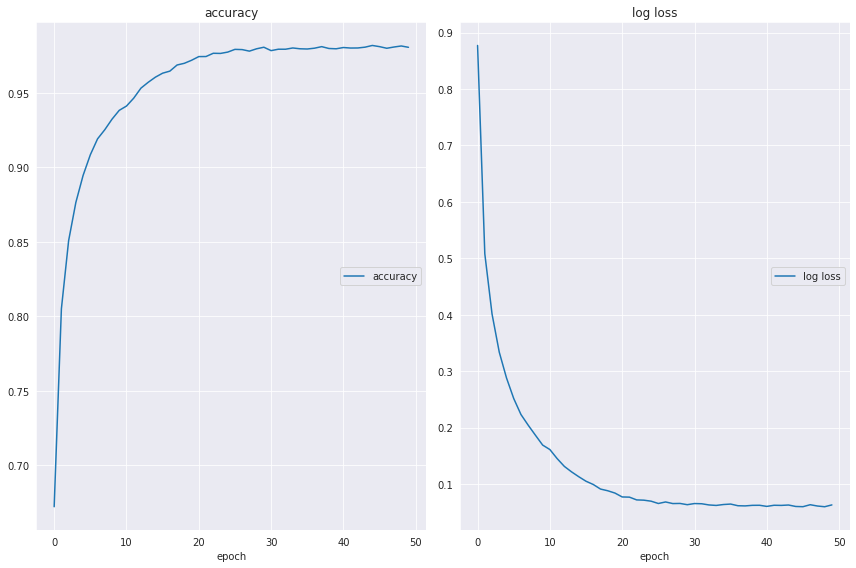

accuracy
	accuracy         	 (min:    0.672, max:    0.982, cur:    0.981)
log loss
	log loss         	 (min:    0.060, max:    0.877, cur:    0.063)
Avg. Train Loss: 0.063  Avg. Train Accuracy: 0.981



['/Mine/wandb/run-20210520_231534-2plurcl4/files/ResNet18_X-ray_classifier_a.pt']

In [49]:
set_seed(config.seed)
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.8, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

wandb.watch(model, log="all")
liveloss = PlotLosses()
for epoch in range(config.epochs):
    logs = {}
    train_loss, train_accuracy = train(config, model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    scheduler.step()

print("Avg. Train Loss: %1.3f" % train_loss.item(), " Avg. Train Accuracy: %1.3f" % train_accuracy.item())
print("")

model_save_name = 'ResNet18_X-ray_classifier_a.pt'
path = './trained_model/{model_save_name}'
torch.save(model.state_dict(), path)
wandb.save('ResNet18_X-ray_classifier_a.pt')

Strategy B:

$Jasmine: lr=0.1, gamma=0.8, wd=0.0001$

In [27]:
X_train, y_train = apply_normalisation(train_data), torch.Tensor(train_targets)
xray_train = TensorDataset(X_train, y_train.long())
train_loader = DataLoader(xray_train, batch_size=config.batch_size, shuffle=True, num_workers=0)
print(X_train.shape)

torch.Size([20215, 224, 224])


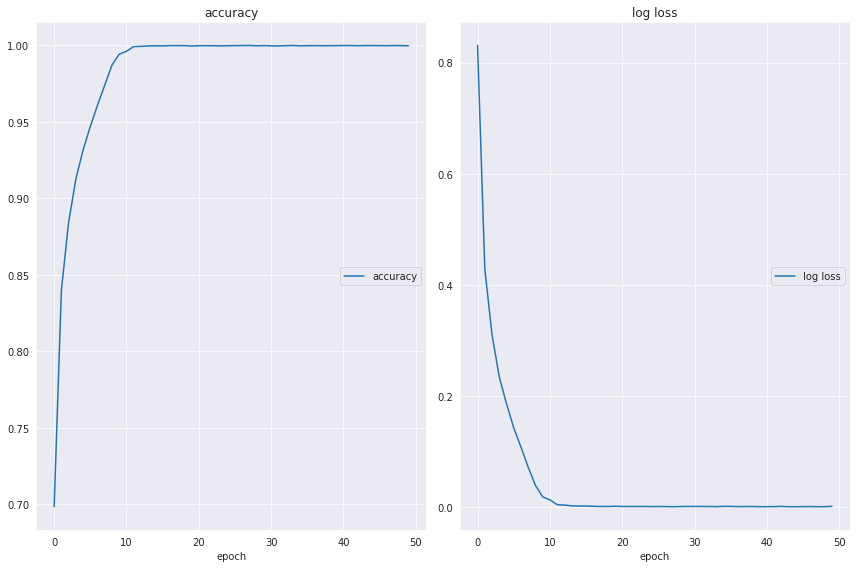

accuracy
	accuracy         	 (min:    0.698, max:    1.000, cur:    1.000)
log loss
	log loss         	 (min:    0.001, max:    0.831, cur:    0.002)
Avg. Train Loss: 0.002  Avg. Train Accuracy: 1.000



['/Mine/wandb/run-20210521_194537-3malpgaj/files/ResNet18_X-ray_classifier_b.pt']

In [28]:
set_seed(config.seed)
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.8, last_epoch=-1)
criterion = nn.CrossEntropyLoss()

wandb.watch(model, log="all")
liveloss = PlotLosses()
for epoch in range(config.epochs):
    logs = {}
    train_loss, train_accuracy = train(config, model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    scheduler.step()

print("Avg. Train Loss: %1.3f" % train_loss.item(), " Avg. Train Accuracy: %1.3f" % train_accuracy.item())
print("")

model_save_name = 'ResNet18_X-ray_classifier_b.pt'
path = './trained_model/{model_save_name}'
torch.save(model.state_dict(), path)
wandb.save('ResNet18_X-ray_classifier_b.pt')

## Test Results

Load pre-trained model if needed. If not, jump this block.

In [104]:
model.load_state_dict(torch.load('./trained_model/ResNet18_X-ray_classifier_a.pt'))

<All keys matched successfully>

Predict test data and print the results to submission file.

In [137]:
test_loader = DataLoader(xray_test, batch_size=config.test_batch_size, shuffle=False, num_workers=0)
y_preds, ys = evaluate(model, test_loader)

In [51]:
df=pd.DataFrame({'name':test_names, 'target':y_preds})
df.to_csv('./submission/ResNet18_a.csv', index=None)

<a id='section_id'></a>

## Strategy to select final submission

We have four alternative classifiers, namely:

$Iris: lr=0.1, gamma=0.8, wd=0.001$

$Jasmine: lr=0.1, gamma=0.8, wd=0.0001$

$Orchid: lr=0.1, gamma=0.8, wd=0.001,$ $with$ $data$ $augmentation$

$Peony: lr=0.1, gamma=0.8, wd=0.0001,$ $with$ $data$ $augmentation$

The kaggle score based on the AUC-ROC metric. The scores in the public leaderboard correspond to a binary classification of covid VS rest-of-classes, and it is not sensitive to all classes. Therefore, we need to analyse the network performance over all classes to achieve a great final score.

### AUC-ROC

Area under the ROC (Receiver Operating Characteristic) curve: AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. [<sup>1</sup>](#refer-anchor-1)

![avatar](./resource/roc-curve.png)

In [28]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    """
    Compute AUC score of multi class classification problem.
    input: 
    actual_class, numpy.ndarray, actual classes.
    pred_class, numpy.ndarray, predicted classes.
    output:
    roc_auc_dict, dictionary, AUC score for all classes.
    """
    
    # creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [138]:
validation_loader = DataLoader(xray_validate, batch_size=config.test_batch_size, shuffle=False, num_workers=0)
y_pred, y_test = evaluate(model, validation_loader)

In [134]:
roc_auc_iris = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_iris

{0: 0.9790761460855391,
 1: 0.9170298423931686,
 2: 0.9778068287629421,
 3: 0.9353433742261534}

In [139]:
roc_auc_jasmine = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_jasmine

{0: 0.9823735273495919,
 1: 0.9132826933376661,
 2: 0.9797523540547708,
 3: 0.9348115078198207}

In [110]:
roc_auc_orchid = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_orchid

{0: 0.9745854473990516,
 1: 0.9240810781534906,
 2: 0.9794882230457903,
 3: 0.9407010001685898}

In [116]:
roc_auc_peony = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_peony

{0: 0.9758612263365674,
 1: 0.9189447142435894,
 2: 0.9796202885502806,
 3: 0.9419485154298843}

In [162]:
roc_auc_iris = pd.Series({0: 0.9790761460855391, 1: 0.9170298423931686, 2: 0.9778068287629421, 3: 0.9353433742261534}, name='iris')
roc_auc_jasmine = pd.Series({0: 0.9823735273495919, 1: 0.9132826933376661, 2: 0.9797523540547708, 3: 0.9348115078198207}, name='jasmine')
roc_auc_orchid = pd.Series({0: 0.9745854473990516, 1: 0.9240810781534906, 2: 0.9794882230457903, 3: 0.9407010001685898}, name='orchid')
roc_auc_peony = pd.Series({0: 0.9758612263365674, 1: 0.9189447142435894, 2: 0.9796202885502806, 3: 0.9419485154298843}, name='peony')

roc_auc = pd.DataFrame()
roc_auc = roc_auc.append(roc_auc_iris)
roc_auc = roc_auc.append(roc_auc_jasmine)
roc_auc = roc_auc.append(roc_auc_orchid)
roc_auc = roc_auc.append(roc_auc_peony)
roc_auc

,0,1,2,3
iris,0.979076,0.917030,0.977807,0.935343
jasmine,0.982374,0.913283,0.979752,0.934812
orchid,0.974585,0.924081,0.979488,0.940701
peony,0.975861,0.918945,0.979620,0.941949


In [163]:
roc_auc.mean(axis=1)

iris       0.952314
jasmine    0.952555
orchid     0.954714
peony      0.954094
dtype: float64

From the above table and average scores, we can see that overall, the best performed classifier is $Orchid$. $Orchid$'s scores in all categories are among the best, especially the score on `lung_opacity` is significantly higher than the others. It is also worth noting that the score of the $Jasmine$ classifier in the `covid` category is also significantly higher than the others.

### Confusion Matrix

Confusion Matrix: A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix. [<sup>1</sup>](#refer-anchor-1)

![avatar](./resource/cm.jpg)

In [98]:
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(actual_class, pred_class):
    """
    Draw confusion matrix of true and predicted labels.
    input:
    actual_class, numpy.ndarray, actual classes.
    pred_class, numpy.ndarray, predicted classes.
    """
    
    plt.figure(figsize = (8, 6))
    ax = sns.heatmap(confusion_matrix(actual_class, pred_class), annot = True, xticklabels = labels, yticklabels = labels, cmap = 'RdPu', fmt='g')
    ax.set_ylim(4.0, 0)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Confusion Matrix of $Iris$

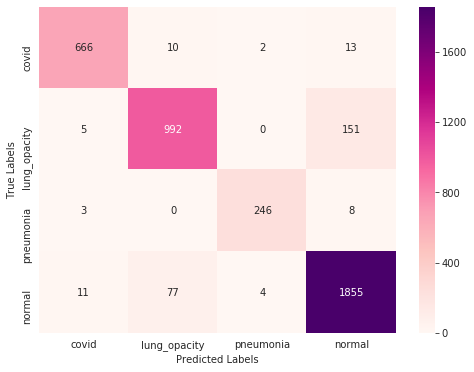

In [135]:
draw_confusion_matrix(y_test, y_pred)

Confusion Matrix of $Jasmine$

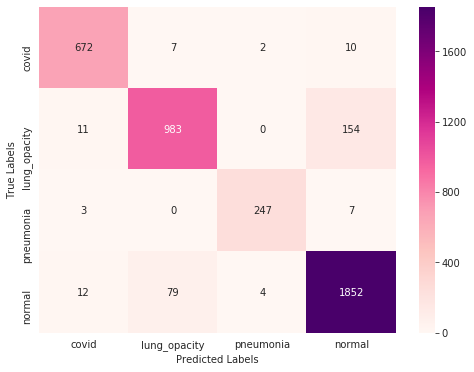

In [140]:
draw_confusion_matrix(y_test, y_pred)

Confusion Matrix of $Orchid$

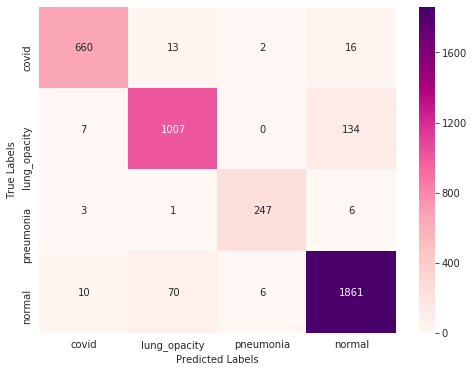

In [112]:
draw_confusion_matrix(y_test, y_pred)

Confusion Matrix of $Peony$

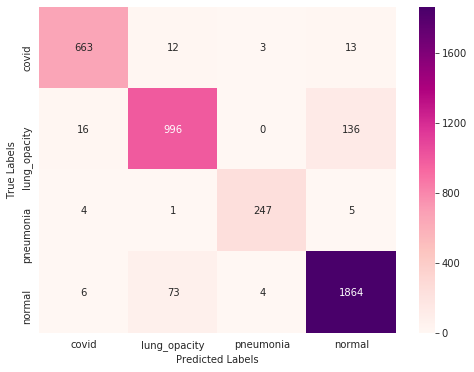

In [117]:
draw_confusion_matrix(y_test, y_pred)

Comparing the four confusion matrices, overall, the accuracy of classification is not much different. The main problem occurs in predicting `lung_opacity` as `normal`, and predicting `normal` as `lung_opacity`. In the predictions of these two labels, the best performed classifier is $Orchid$, follwed with $Peony$. $Iris$ and $Jasmine$ perform slightly inferior in the classification of these two labels, but perform well in the classification of `covid`.

Combining the evaluation results of AUC-ROC and confusion matrix, we choose the prediction results of $Orchid$ and $Jasmine$ as the final submission files. Among them, $Orchid$ performs better in the predictions of each category, and scores more balanced; $Jasmine$ is more like a specialized strategy for covid predictions.

![avatar](./resource/score.jpg)

The above is the final Kaggle score. $Orchid$'s result is `ResNet18_a.csv`, and $Jasmine$'s result is `ResNet18_b.csv`. It can be seen that $Jasmine$ scored very high on the test set sensitive to `covid` (Public Score); on the larger balanced test set, $Orchid$ performed better (Private Score).

## Reference

<div id="refer-anchor-1"></div>

- [1] [Evaluation Metrics For Multi-class Classification](https://www.kaggle.com/nkitgupta/evaluation-metrics-for-multi-class-classification)
